# Regularization in MDPs

In the following notebook we look at introducing regularization in MDPs.

In [1]:
""" Includes """
import jax
from jax import numpy as jnp
import jax.nn as nn
import matplotlib.pyplot as plt
from env.mdp import Sampler
from env.gridworld import Gridworld, gridplot
from algs.policy_gradients import PolicyGradientMethod, vanillaGradOracle, naturalGradOracle, monteCarloVanillaGrad, Sampler, monteCarloNaturalGrad, sample_batch
from itertools import accumulate

def flatten(v):
    return jnp.reshape(v,(list(accumulate(v.shape,lambda x,y:x*y))[-1],))

""" Initialize the Jax RNG """
key = jax.random.PRNGKey(0) 
from jax.config import config; config.update("jax_enable_x64", True)

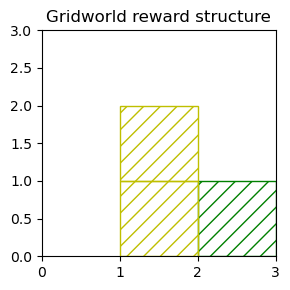

In [2]:
R = 100
P = -300
goals = [((2,0),R),((1,0),P),((1,1),P)]
gridMDP = Gridworld(3,3,0.1,0.9,goals=goals,obstacles=[]) 
gridMDP.init_distrib =  jnp.exp(jax.random.uniform(key,(gridMDP.n,))) / \
    jnp.sum(jnp.exp(jax.random.uniform(key,(gridMDP.n,))))
    
    
fig, ax = plt.subplots(1,figsize=(3,3))
gridplot(gridMDP,ax,goals=goals)
ax.set_title('Gridworld reward structure')
fig.tight_layout()
plt.show()

We also choose to use a direct `softmax` policy parametrization, which we define here:

In [3]:
"""We define our policy parametrization"""
parametrization = lambda p : nn.softmax(p,axis=1)
"""As well as some random policy parameter vector"""
theta = jax.random.uniform(key,(gridMDP.n,gridMDP.m)) # where the dimensionality matches the MDP

### Introducing Regularization into Vanilla PG with oracles

In [4]:
BETA = 20
STEPS = 10
LR = 0.5
theta = jax.random.uniform(key,(gridMDP.n,gridMDP.m))
pi_theta = nn.softmax(theta,axis=1)

shannonEntropy = lambda p : jnp.dot(jnp.log(p),p)
reg = lambda p : BETA*shannonEntropy(p)
parametrization = lambda p : nn.softmax(p,axis=1)
vanillaGradReg = vanillaGradOracle(gridMDP, None, key, parametrization, 1,1,reg)
vanillaGradUnreg = vanillaGradOracle(gridMDP, None, key, parametrization, 1,1,None)

def logger(theta):
    return {
        'theta': theta,
        'pi': parametrization(theta),
        'J': gridMDP.J(parametrization(theta))
    }
        
alg_reg = PolicyGradientMethod(gridMDP,key,vanillaGradReg,logger)
alg_unreg = PolicyGradientMethod(gridMDP,key,vanillaGradUnreg,logger)
log_reg, theta_reg = alg_reg.train(STEPS,LR)
log_unreg, theta_unreg = alg_unreg.train(STEPS,LR)

100%|██████████| 10/10 [00:00<00:00, 37.11it/s]


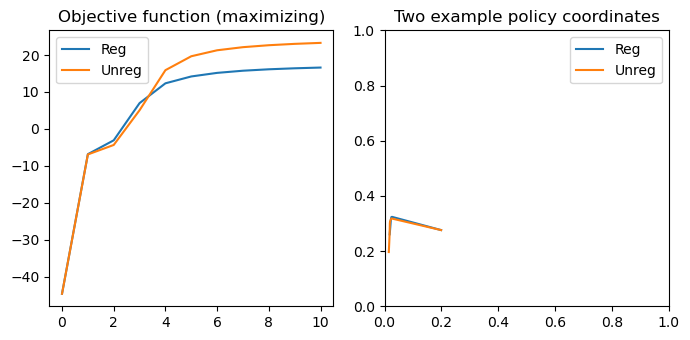

In [5]:
scale = 0.7; fig, ax = plt.subplots(1,2,figsize=(scale*10,scale*5))
ax[0].set_title('Objective function (maximizing)');ax[1].set_title('Two example policy coordinates')

pis=jnp.stack([e['pi'] for e in log_reg])
js=jnp.stack([e['J'] for e in log_reg])
ax[0].plot(js); ax[1].plot(pis[:,0,0],pis[:,0,1])
pis=jnp.stack([e['pi'] for e in log_unreg])
js=jnp.stack([e['J'] for e in log_unreg])
ax[0].plot(js); ax[1].plot(pis[:,0,0],pis[:,0,1])
ax[1].set_xlim([0,1]);ax[1].set_ylim([0,1])
ax[0].legend(['Reg','Unreg'])
ax[1].legend(['Reg','Unreg'])
fig.tight_layout()
plt.show()

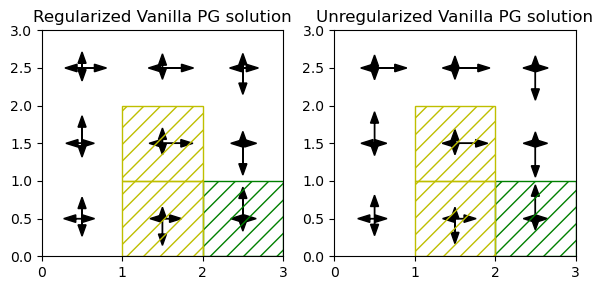

In [6]:
fig, ax = plt.subplots(1,2,figsize=(6,3,))
pis=jnp.stack([e['pi'] for e in log_reg])
gridplot(gridMDP,ax[0],stochastic_policy=pis[-1],goals=goals)
ax[0].set_title('Regularized Vanilla PG solution')
pis=jnp.stack([e['pi'] for e in log_unreg])
gridplot(gridMDP,ax[1],stochastic_policy=pis[-1],goals=goals)
ax[1].set_title('Unregularized Vanilla PG solution')
fig.tight_layout()

### Introducing Regularization into Natural PG with oracles

In [7]:
BETA = 20
STEPS = 10
LR = 5e-2
theta = jax.random.uniform(key,(gridMDP.n,gridMDP.m))
pi_theta = nn.softmax(theta,axis=1)

shannonEntropy = lambda p : jnp.dot(jnp.log(p),p)
reg = lambda p : BETA*shannonEntropy(p)
parametrization = lambda p : nn.softmax(p,axis=1)
naturalGradReg = naturalGradOracle(gridMDP, None, key, parametrization, 1,1,reg)
naturalGradUnreg = naturalGradOracle(gridMDP, None, key, parametrization, 1,1,None)

def logger(theta):
    return {
        'theta': theta,
        'pi': parametrization(theta),
        'J': gridMDP.J(parametrization(theta))
    }
        
alg_reg = PolicyGradientMethod(gridMDP,key,naturalGradReg,logger)
alg_unreg = PolicyGradientMethod(gridMDP,key,naturalGradUnreg,logger)
log_reg, theta_reg = alg_reg.train(STEPS,LR)
log_unreg, theta_unreg = alg_unreg.train(STEPS,LR)

100%|██████████| 10/10 [00:00<00:00, 14.42it/s]


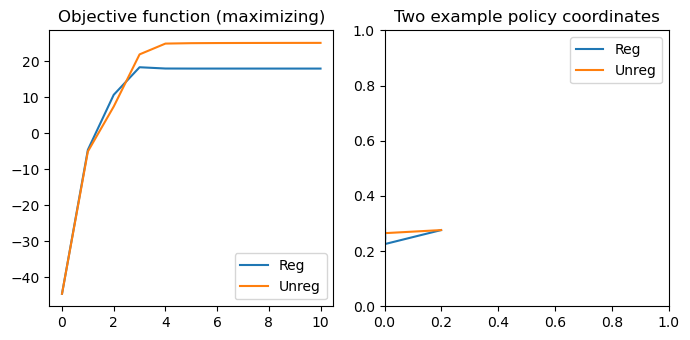

In [8]:
scale = 0.7; fig, ax = plt.subplots(1,2,figsize=(scale*10,scale*5))
ax[0].set_title('Objective function (maximizing)');ax[1].set_title('Two example policy coordinates')

pis=jnp.stack([e['pi'] for e in log_reg])
js=jnp.stack([e['J'] for e in log_reg])
ax[0].plot(js); ax[1].plot(pis[:,0,0],pis[:,0,1])
pis=jnp.stack([e['pi'] for e in log_unreg])
js=jnp.stack([e['J'] for e in log_unreg])
ax[0].plot(js); ax[1].plot(pis[:,0,0],pis[:,0,1])
ax[1].set_xlim([0,1]);ax[1].set_ylim([0,1])
ax[0].legend(['Reg','Unreg'])
ax[1].legend(['Reg','Unreg'])
fig.tight_layout()
plt.show()

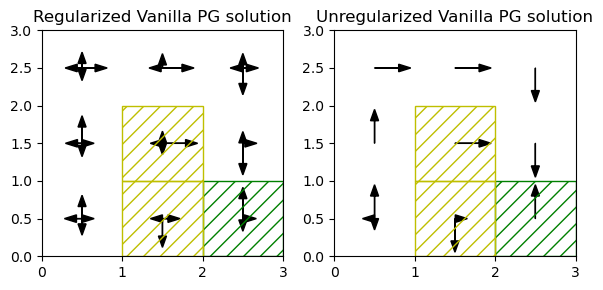

In [9]:
fig, ax = plt.subplots(1,2,figsize=(6,3,))
pis=jnp.stack([e['pi'] for e in log_reg])
gridplot(gridMDP,ax[0],stochastic_policy=pis[-1],goals=goals)
ax[0].set_title('Regularized Vanilla PG solution')
pis=jnp.stack([e['pi'] for e in log_unreg])
gridplot(gridMDP,ax[1],stochastic_policy=pis[-1],goals=goals)
ax[1].set_title('Unregularized Vanilla PG solution')
fig.tight_layout()

### Introducing Regularization into Vanilla PG with MC-Sampling

For the stochastic implementation we sample the regularized rewards, thus it is the sampler that accepts the regularizer (not the gradient oracle).

In [10]:
sampler = Sampler(gridMDP,key)

In [14]:
STEPS = 10
LR_VPG = 5e-2
LR_NPG = 1e-3
HORIZON = 10
BATCH = 10
mCVanillaGrad = monteCarloVanillaGrad(
                               gridMDP,
                               sampler,
                               key,
                               parametrization,
                               HORIZON,BATCH,reg)

# mCNaturalGrad = monteCarloNaturalGrad(
#                                gridMDP,
#                                sampler,
#                                key,
#                                parametrization,
#                                HORIZON,BATCH,reg)

alg_mc_vanilla = PolicyGradientMethod(gridMDP,key,mCVanillaGrad,logger)
# alg_mc_natural = PolicyGradientMethod(gridMDP,key,mCNaturalGrad,logger,clip_thresh=1e3)
log_v, theta_v = alg_mc_vanilla.train(STEPS,LR_VPG)
# log_n, theta_n = alg_mc_natural.train(STEPS,LR_NPG)

100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


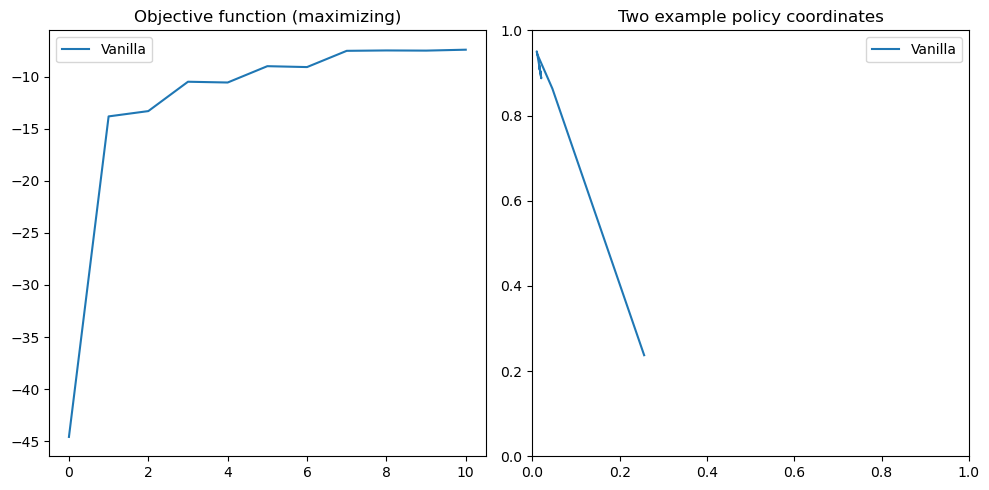

In [13]:
PI_COORD = 3
def plot_perf_pis(log,ax):
    js=jnp.stack([e['J'] for e in log])
    pis=jnp.stack([e['pi'] for e in log])
    ax[0].plot(js)
    ax[1].plot(pis[:,PI_COORD,0],pis[:,PI_COORD,1])
    
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_perf_pis(log_v,ax)
# plot_perf_pis(log_n,ax)
ax[0].set_title('Objective function (maximizing)')
ax[1].set_title('Two example policy coordinates')
ax[1].set_xlim([0,1]);ax[1].set_ylim([0,1])
ax[0].legend(['Vanilla','NPG']);ax[1].legend(['Vanilla','NPG'])
fig.tight_layout(); plt.show()